# Settings, Directory Specs, and Imports

In [1]:
#file_name_pickle_read = 'model_2020_06_06_1105.pickle'
dir_read = '../data/preprocessed/'

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, confusion_matrix, plot_confusion_matrix, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, learning_curve, train_test_split, ShuffleSplit, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import streamlit as st
import pickle
from datetime import datetime
from sklearn.model_selection._split import _BaseKFold
from sklearn.model_selection._split import _RepeatedSplits
from collections import defaultdict
from collections import Counter
import sys
sys.path.insert(1, '../src')
from utils import *

matplotlib.rcParams.update({'font.size': 22})

# Defining X and y

In [2]:
Xy = pd.read_csv(dir_read + 'Xy_2020_06_20_2258.csv')
Xy = Xy.set_index('patientunitstayid')
y = Xy.pop('label')
X = Xy.copy()
groups = Xy['uniquepid'].astype('category').cat.codes # each uniquepid is now a unique number
X = X.drop(columns='uniquepid', axis=1) # remove uniquepid as a feature because it's a group

vars_categ = ['gender_Female', 'ethnicity_African American', 'ethnicity_Asian', 'ethnicity_Caucasian', \
             'ethnicity_Hispanic', 'ethnicity_Native American', 'ethnicity_Other/Unknown',\
             'thrombolytics', 'aids', 'hepaticfailure', 'lymphoma', 'metastaticcancer', 'leukemia', \
             'immunosuppression', 'cirrhosis', 'activetx', 'ima', 'midur',
             'oobventday1', 'oobintubday1', 'diabetes']
vars_cont = ['age', 'admissionweight', 'admissionheight', 'bmi', \
             'verbal', 'motor', 'eyes', 'visitnumber', 'heartrate']
print('There are ' + str(len(vars_categ)) + ' categorical features')
print('There are ' + str(len(vars_cont)) + ' continuous features')
X = pd.concat([X[vars_cont], X[vars_categ]], axis=1)
X.head()

There are 21 categorical features
There are 9 continuous features


,age,admissionweight,admissionheight,bmi,verbal,motor,eyes,visitnumber,heartrate,gender_Female,...,metastaticcancer,leukemia,immunosuppression,cirrhosis,activetx,ima,midur,oobventday1,oobintubday1,diabetes
patientunitstayid,,,,,,,,,,,,,,,,,,,,,
141168,70,84.3,152.4,36.295906,5,6,4,1,125.052830,1,...,0,0,0,0,1,0,0,0,0,0
141194,68,73.9,180.3,22.732803,4,6,3,1,86.860627,0,...,0,0,0,0,0,0,0,0,0,1
141197,71,102.1,162.6,38.617545,5,6,4,1,97.307692,0,...,0,0,0,0,0,0,0,0,0,0
141203,77,70.2,160.0,27.421875,1,3,1,1,91.543554,1,...,0,0,0,0,1,0,0,1,0,1
141208,25,95.3,172.7,31.952749,5,6,3,1,77.817460,1,...,0,0,0,0,0,0,0,0,0,0


## Split into X_trainval, y_trainval, X_test, y_test using StratifiedGroupKFold()

In [3]:
# Split into 80/20 train&val/test using StratifiedGroupKFold(). Since 
cv = StratifiedGroupKFold(n_splits = 5, shuffle=True, random_state=1)
trainval_idx, test_idx = next(cv.split(X, y, groups))
X_trainval = X.iloc[trainval_idx]
y_trainval = y.iloc[trainval_idx]
X_test = X.iloc[test_idx]
y_test = y.iloc[test_idx]

In [4]:
X_trainval.shape

(116993, 30)

In [5]:
X_test.shape

(29249, 30)

# Vanilla Random Forest

In [6]:
%matplotlib notebook
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)
# scaler = MinMaxScaler()
# # X_train_sc = scaler.fit_transform(X_train[vars_cont])
# # X_test_sc = scaler.transform(X_test[vars_cont])

# X_train_sc = np.concatenate([scaler.fit_transform(X_train[vars_cont]), \
#                              X_train[vars_categ].to_numpy()], axis=1)
# X_test_sc = np.concatenate([scaler.fit_transform(X_test[vars_cont]), \
#                              X_test[vars_categ].to_numpy()], axis=1)

mylabel = 'Random Forest'
clf = RandomForestClassifier(n_estimators=5000, class_weight='balanced', n_jobs=-1)
clf.fit(X_trainval, y_trainval)
y_pred = clf.predict(X_test)
y_probs = clf.predict_proba(X_test)[:,1]
print('AUC is ' + str(roc_auc_score(y_test,y_probs)))

lr_fpr, lr_tpr, threshold_array = roc_curve(y_test, y_probs)
noskill_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, noskill_probs)

auc = roc_auc_score(y_test, y_probs)
print('{}: AUC = {:.3f}'.format(mylabel, auc))



AUC is 0.6668801052846597
Random Forest: AUC = 0.667


<IPython.core.display.Javascript object>


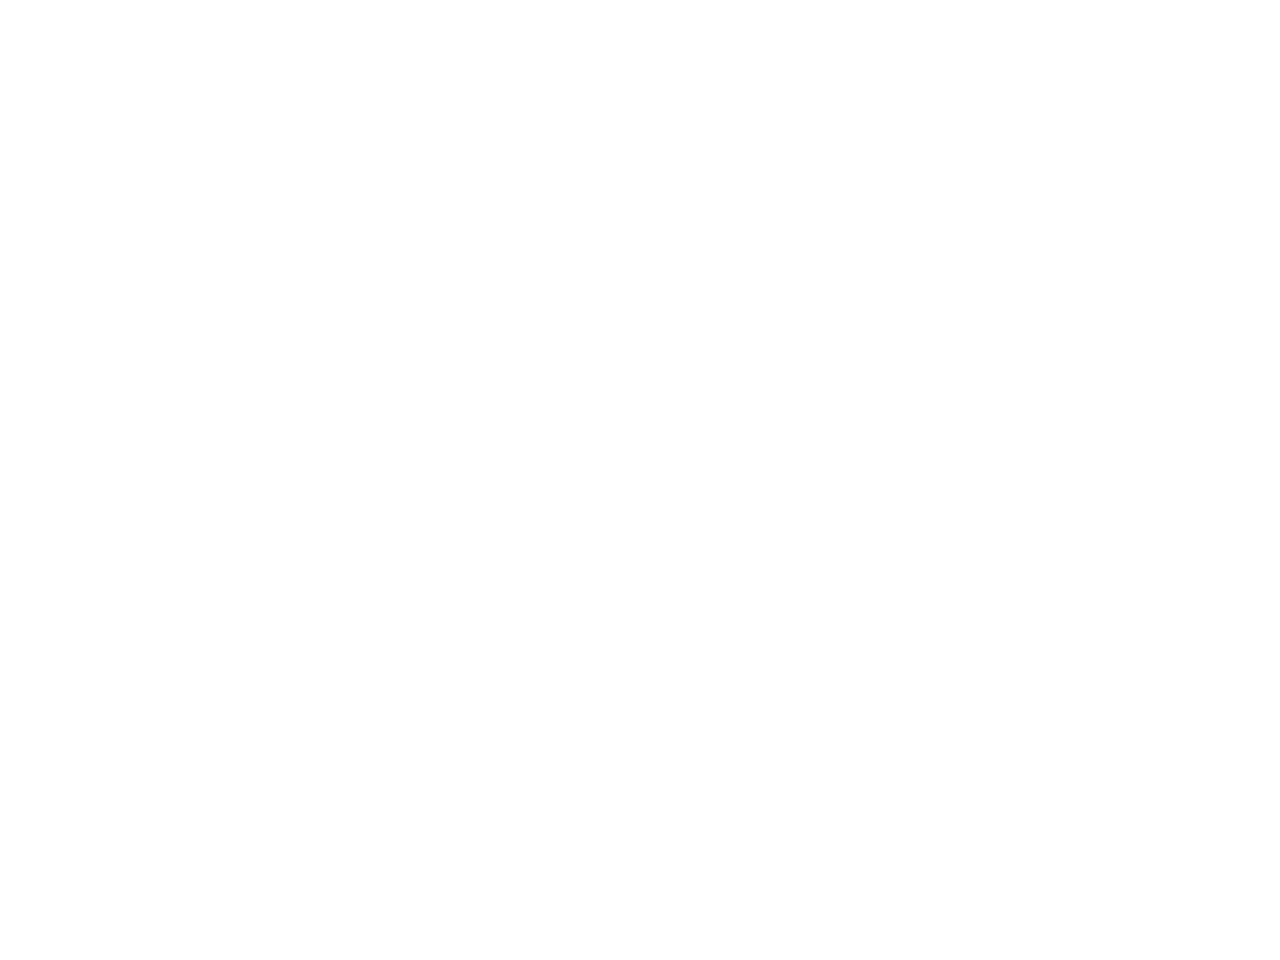

In [7]:
noskill_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, noskill_probs)
matplotlib.rcParams.update({'font.size': 16})
plt.figure()
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--')
plt.plot(lr_fpr, lr_tpr, marker='.', label=mylabel)
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# # show the legend
plt.legend()
plt.tight_layout()
# # show the plot
plt.show()
plt.title('{}: AUC = {:.3f}'.format(mylabel, auc))
plt.tight_layout()

In [8]:
from pprint import pprint
print('Parameters currently in use:\n')
pprint(clf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 5000,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


# Random Search w/ Random Forest

In [9]:
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, truncnorm, randint
# Number of trees in random forest
#n_estimators = [int(x) for x in np.linspace(start = 1000, stop = 5000, num = 4)]
n_estimators = [2000, 5000]
max_features = [3,  5, 10, 30]
# # Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 4)]
max_depth.append(None)
# Minimum number of samples required to split a node
#min_samples_split = [2, 10]
# Minimum number of samples reqiuired at each leaf node
# min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
# bootstrap = [True, False]
# Create the random grid
random_grid = {'max_depth': max_depth,
               'n_estimators': n_estimators,
               'max_features': max_features}
               #'min_samples_split': min_samples_split}
print(random_grid)

{'max_depth': [10, 40, 70, 100, None], 'n_estimators': [2000, 5000], 'max_features': [3, 5, 10, 30]}


In [10]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(class_weight='balanced', n_jobs=4)
# Random search of parameters, using 3 fold cross validation, 
# search across 10 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, \
                               cv = StratifiedKFold(5), verbose=2, random_state=42, scoring = 'roc_auc', n_jobs = -1)
# Fit the random search model
model = rf_random.fit(X_trainval, y_trainval)
pickle.dump(model, open('../models/model_' + now_to_str() + '.pickle', 'wb'))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed: 77.3min remaining:  8.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 88.7min finished


In [11]:
rf_random.best_params_

{'n_estimators': 2000, 'max_features': 10, 'max_depth': 10}

In [12]:
y_pred = model.predict(X_test)
y_probs = model.predict_proba(X_test)[:,1]
print('AUC is ' + str(roc_auc_score(y_test,y_probs)))

AUC is 0.6880727133487953


In [13]:
y_probs.max()

0.7676948796315147

In [14]:
plt.hist(y_probs, bins=20)

(array([4714., 3549., 2276., 2460., 2852., 2723., 2253., 1772., 1381.,
        1154.,  981.,  800.,  690.,  529.,  398.,  346.,  232.,  105.,
          28.,    6.]),
 array([0.00686723, 0.04490861, 0.08294999, 0.12099137, 0.15903276,
        0.19707414, 0.23511552, 0.2731569 , 0.31119829, 0.34923967,
        0.38728105, 0.42532244, 0.46336382, 0.5014052 , 0.53944658,
        0.57748797, 0.61552935, 0.65357073, 0.69161211, 0.7296535 ,
        0.76769488]),
 <a list of 20 Patch objects>)

Random Forest: ROC AUC=0.688


<IPython.core.display.Javascript object>


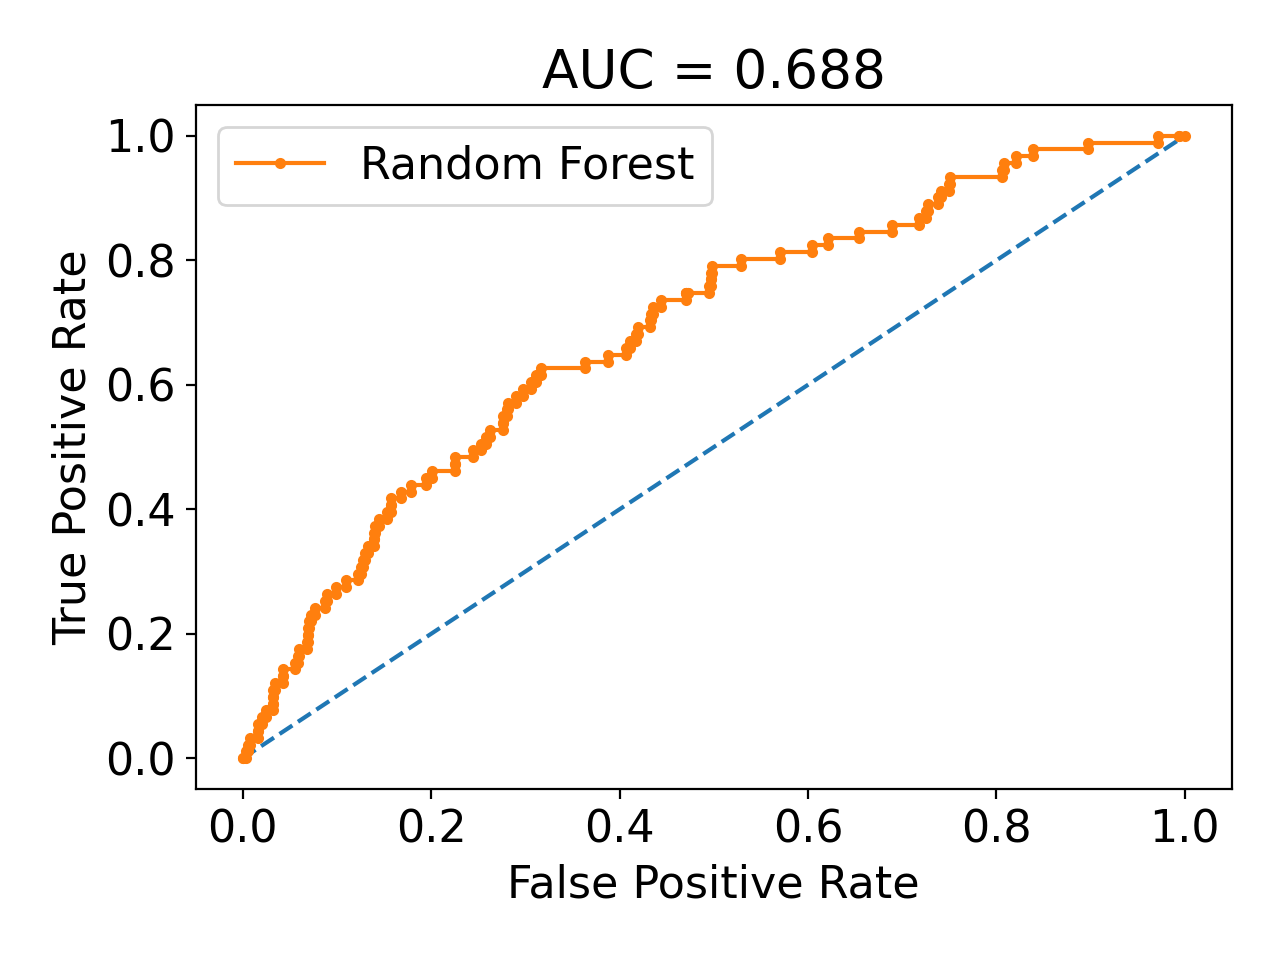

In [16]:
%matplotlib notebook

mylabel = 'Random Forest'

noskill_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, noskill_probs)
lr_fpr, lr_tpr, threshold_array = roc_curve(y_test, model.predict_proba(X_test)[:,1])

y_pred_new = lr_tpr>0

auc = roc_auc_score(y_test, y_probs)
print(mylabel + ': ROC AUC=%.3f' % (auc))

plt.figure()
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--')
plt.plot(lr_fpr, lr_tpr, marker='.', label=mylabel)
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# # show the legend
plt.legend()
plt.tight_layout()
# # show the plot
plt.show()
plt.title('AUC = {:.3f}'.format(auc))
plt.tight_layout()